**This notebook walks you through the process of evaluation and plotting of SinkSAM paper**.
<p>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot ground truth and multiple rasters, and save the plot in a column layout
def plot_rasters_in_column(ground_truth, rasters, titles, save_path):
    num_rasters = len(rasters) + 1  # Include ground truth
    fig, axs = plt.subplots(num_rasters, 1, figsize=(12, 24))  # Adjust the figure size for column layout (12x24 inches)

    # Plot ground truth
    axs[0].imshow(ground_truth, cmap='gray')
    axs[0].set_title('Ground Truth')

    # Plot prediction and other rasters
    for i in range(num_rasters - 1):
        axs[i + 1].imshow(rasters[i], cmap='gray')
        axs[i + 1].set_title(titles[i])

    plt.tight_layout()

    # Save the plot
    plt.savefig(save_path, dpi=300)  # Save the figure with 300 DPI for high quality
    plt.show()

# Paths to your rasters
ground_truth_raster_path = "C://Users/osher/Downloads/results/final/gt_final.tif"
prediction_raster_paths = [
    "C://Users/osher/Downloads/results/final/sam_pred_box_best.tif",
    "C://Users/osher/Downloads/results/final/com_hydro.tif",
    "C://Users/osher/Downloads/results/final/Extract_sam_yolov9.tif",
    "C://Users/osher/Downloads/results/final/Extract_sam_non_ft.tif"
]

# Get the bounding box of the non-zero prediction area
bbox = get_prediction_bounding_box(prediction_raster_paths[0])  # Use the first prediction for bounding box

# Load and clip all rasters
try:
    ground_truth_clipped = load_and_clip_raster(ground_truth_raster_path, bbox)
    
    predictions_clipped = [
        load_and_clip_raster(prediction_raster_path, bbox) for prediction_raster_path in prediction_raster_paths
    ]

    # Titles for the predictions
    prediction_titles = ['SAM Prediction', 'Com', 'YOLOv9&SAM', 'Non-fine tuned SAM Prediction']

    # Path to save the figure
    save_path = "C://Users/osher/Downloads/results/comparison_plot_column.png"

    # Plot the ground truth and the predictions in a column
    plot_rasters_in_column(ground_truth_clipped, predictions_clipped, prediction_titles, save_path)

except ValueError as e:
    print("Clipping failed. Ensure rasters overlap or check CRS consistency:", str(e))


In [ ]:
import seaborn as sns
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from shapely.geometry import box
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, jaccard_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Function to compute metrics
def compute_metrics(ground_truth, prediction):
    ground_truth_flat = ground_truth.flatten()
    prediction_flat = prediction.flatten()

    # Compute confusion matrix components
    tn, fp, fn, tp = confusion_matrix(ground_truth_flat, prediction_flat, labels=[0, 1]).ravel()

    # Calculate metrics
    precision = precision_score(ground_truth_flat, prediction_flat)
    recall = recall_score(ground_truth_flat, prediction_flat)
    accuracy = accuracy_score(ground_truth_flat, prediction_flat)
    f1 = f1_score(ground_truth_flat, prediction_flat)
    iou = jaccard_score(ground_truth_flat, prediction_flat)
    
    # Calculate FPR (False Positive Rate)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # Calculate True Negative Rate (Specificity)
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Calculate Dice coefficient
    dice = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

    # Confusion matrix
    conf_matrix = confusion_matrix(ground_truth_flat, prediction_flat, labels=[0, 1])

    return precision, recall, accuracy, f1, iou, fpr, tnr, dice, conf_matrix

# Paths to your rasters
ground_truth_raster_path = "C://Users/osher/Downloads/results/final/gt_final.tif"
prediction_raster_path = "C://Users/osher/Downloads/results/final/Extract_sam_yolov9.tif"

# Clip and resample the ground truth and prediction rasters
try:
    ground_truth_clipped, prediction_clipped = clip_and_resample_rasters(ground_truth_raster_path, prediction_raster_path)
except ValueError as e:
    print("Clipping failed:", str(e))

# Ensure both rasters have the same dimensions
if ground_truth_clipped.shape == prediction_clipped.shape:
    precision, recall, accuracy, f1, iou, fpr, tnr, dice, conf_matrix = compute_metrics(ground_truth_clipped, prediction_clipped)

    # Print the results
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"IoU: {iou}")
    print(f"FPR: {fpr}")
    print(f"TNR (Specificity): {tnr}")
    print(f"Dice Coefficient: {dice}")

    # Plot the confusion matrix as a heatmap (without normalization)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Background', 'Predicted Sinkhole'],
                yticklabels=['Actual Background', 'Actual Sinkhole'])
    plt.xlabel('Predicted Pixels')
    plt.ylabel('True Pixels')
    plt.title('Confusion Matrix (Pixel Counts)')
    plt.show()

    # Plot the Precision-Recall curve and ROC curve
    ground_truth_flat = ground_truth_clipped.flatten()
    prediction_flat = prediction_clipped.flatten()

    # Precision-Recall curve
    precisions, recalls, _ = precision_recall_curve(ground_truth_flat, prediction_flat)
    plt.figure(figsize=(10, 5))
    plt.plot(recalls, precisions, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ROC curve
    fpr_curve, tpr_curve, _ = roc_curve(ground_truth_flat, prediction_flat)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr_curve, tpr_curve, label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the rasters
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(ground_truth_clipped), cmap='gray')
    plt.title('Clipped Ground Truth')

    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(prediction_clipped), cmap='gray')
    plt.title('Clipped Prediction')

    plt.show()
else:
    print("Ground truth and prediction rasters do not have matching dimensions.")


In [12]:
import numpy as np
import rasterio
from scipy.ndimage import label
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio.features

# Function to convert mask to shapefile
def save_mask_as_shapefile(mask, transform, output_path, min_size=50):
    labeled_mask, num_labels = label(mask)
    sizes = np.bincount(labeled_mask.ravel())
    mask_sizes = sizes >= min_size  # Keep only masks larger than min_size
    mask_sizes[0] = 0  # Background should not be counted
    filtered_mask = mask_sizes[labeled_mask]
    
    # Convert to polygons
    shapes = rasterio.features.shapes(filtered_mask.astype(np.int16), transform=transform)
    
    # Create a GeoDataFrame from the polygons
    polygons = []
    for shape, value in shapes:
        if value > 0:
            polygons.append(Polygon(shape['coordinates'][0]))

    gdf = gpd.GeoDataFrame({'geometry': polygons, 'id': range(len(polygons))})
    gdf.to_file(output_path, driver='ESRI Shapefile')

# Load the raster and save it as shapefiles
ground_truth_raster_path = "D:/Osher/ann_osher/sinkholes_yolo_dataset/final/final/gt_final.tif"
prediction_raster_paths = [
    "D:/Osher/ann_osher/sinkholes_yolo_dataset/final/final/com_hdem.tif",
    "D:/Osher/ann_osher/sinkholes_yolo_dataset/final/final/com_hydro.tif",
    "D:/Osher/ann_osher/sinkholes_yolo_dataset/final/final/Extract_sam_yolov9.tif",
    "D:/Osher/ann_osher/sinkholes_yolo_dataset/final/final/Extract_sam_non_ft.tif",
    "D:/Osher/ann_osher/sinkholes_yolo_dataset/final/final/sam_pred_box_best.tif"
]

output_shapefiles = [
    "D:/Osher/ann_osher/sinkholes_yolo_dataset/shapefiles/gt_final.shp",
    "D:/Osher/ann_osher/sinkholes_yolo_dataset/shapefiles/com_hdem.shp",
    "D:/Osher/ann_osher/sinkholes_yolo_dataset/shapefiles/com_hydro.shp",
    "D:/Osher/ann_osher/sinkholes_yolo_dataset/shapefiles/Extract_sam_yolov9.shp",
    "D:/Osher/ann_osher/sinkholes_yolo_dataset/shapefiles/Extract_sam_non_ft.shp",
    "D:/Osher/ann_osher/sinkholes_yolo_dataset/shapefiles/sam_pred_box_best.shp"
]

# Save each raster as a shapefile
for raster_path, output_path in zip([ground_truth_raster_path] + prediction_raster_paths, output_shapefiles):
    with rasterio.open(raster_path) as src:
        mask = src.read(1)
        mask[mask != 1] = 0  # Ensure only 1s and 0s
        save_mask_as_shapefile(mask, src.transform, output_path)


In [16]:
import numpy as np ##to activate
import geopandas as gpd
import pickle

# Function to compute IoU between two polygons
def compute_iou_polygon(poly1, poly2):
    intersection = poly1.intersection(poly2).area
    union = poly1.union(poly2).area
    return intersection / union if union > 0 else 0

# Function to compute confusion matrix
def compute_confusion_matrix(tp, fp, fn):
    tn = 0  # True negatives aren't directly computable from TP, FP, and FN in this context
    return np.array([[tn, fp], [fn, tp]])

# Load the ground truth shapefile
ground_truth_gdf = gpd.read_file("D:/Osher/ann_osher/sinkholes_yolo_dataset/shapefiles/gt_final.shp")

# List to store metrics and confusion matrices
all_f1_scores = []
all_precision_scores = []
all_recall_scores = []
all_conf_matrices = []

# Define IoU thresholds to evaluate with more points
iou_thresholds = np.arange(0.1, 0.9, 0.1)

# Process each prediction shapefile
for pred_shapefile in output_shapefiles[1:]:
    pred_gdf = gpd.read_file(pred_shapefile)
    
    f1_scores = []
    precision_scores = []
    recall_scores = []
    conf_matrices = []
    
    for threshold in iou_thresholds:
        tp, fp, fn = 0, 0, 0
        
        # Match ground truth and prediction polygons
        for _, gt_poly in ground_truth_gdf.iterrows():
            best_iou = 0
            for _, pred_poly in pred_gdf.iterrows():
                iou = compute_iou_polygon(gt_poly['geometry'], pred_poly['geometry'])
                if iou > best_iou:
                    best_iou = iou
        
            if best_iou >= threshold:
                tp += 1
            else:
                fn += 1
        
        fp = len(pred_gdf) - tp
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Compute confusion matrix
        conf_matrix = compute_confusion_matrix(tp, fp, fn)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        conf_matrices.append(conf_matrix)

    all_f1_scores.append(f1_scores)
    all_precision_scores.append(precision_scores)
    all_recall_scores.append(recall_scores)
    all_conf_matrices.append(conf_matrices)

# Save the computed metrics and confusion matrices to files
with open('iou_thresholds.pkl', 'wb') as f:
    pickle.dump(iou_thresholds, f)

with open('f1_scores.pkl', 'wb') as f:
    pickle.dump(all_f1_scores, f)

with open('precision_scores.pkl', 'wb') as f:
    pickle.dump(all_precision_scores, f)

with open('recall_scores.pkl', 'wb') as f:
    pickle.dump(all_recall_scores, f)

with open('conf_matrices.pkl', 'wb') as f:
    pickle.dump(all_conf_matrices, f)


In [4]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import matplotlib.patheffects as PathEffects

# Define colors for different models
colors = ['#DDA0DD', '#32CD32', '#FFA500', '#1E90FF', '#FFD700']

# Define model names (Ensure this list is defined)
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']  # Update as needed

# Set global font size
def set_global_font_size(font_size):
    plt.rcParams.update({'font.size': font_size})

# Adjust the font size here
set_global_font_size(18)  # Example: Set the font size to 14

# Load the saved metrics and confusion matrices
with open('iou_thresholds.pkl', 'rb') as f:
    iou_thresholds = pickle.load(f)

with open('f1_scores.pkl', 'rb') as f:
    all_f1_scores = pickle.load(f)

with open('precision_scores.pkl', 'rb') as f:
    all_precision_scores = pickle.load(f)

with open('recall_scores.pkl', 'rb') as f:
    all_recall_scores = pickle.load(f)

# Ensure that the lengths of thresholds and metrics match
num_thresholds = len(iou_thresholds)

all_f1_scores = [scores[:num_thresholds] for scores in all_f1_scores]
all_precision_scores = [scores[:num_thresholds] for scores in all_precision_scores]
all_recall_scores = [scores[:num_thresholds] for scores in all_recall_scores]

# Interpolate the curves to make them smoother
def interpolate_curve(x, y):
    x_new = np.linspace(x.min(), x.max(), 300)
    spline = make_interp_spline(x, y, k=3)  # k=3 for cubic spline
    y_smooth = spline(x_new)
    return x_new, y_smooth

# Define a function to create and save plots
def create_and_save_plot(metric_values, metric_name, file_name):
    plt.figure(figsize=(5, 5), dpi=300, facecolor='none')
    ax = plt.gca()
    ax.set_facecolor('none')
    
    for i, model_name in enumerate(model_names):
        iou_interp, metric_interp = interpolate_curve(np.array(iou_thresholds), np.array(metric_values[i]))
        if colors[i] == '#FFD700':  # Apply halo only to the yellow line
            plt.plot(iou_interp, metric_interp, label=model_name, color=colors[i], linestyle='--', linewidth=2,
                     path_effects=[PathEffects.withStroke(linewidth=5, foreground='black')])
        else:
            plt.plot(iou_interp, metric_interp, label=model_name, color=colors[i], linestyle='--', linewidth=2)
    
    plt.xlabel('IoU Threshold')
    plt.ylabel(metric_name)
    plt.tight_layout()
    plt.savefig(f'{file_name}.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.close()

# Create and save F1 Score plot
create_and_save_plot(all_f1_scores, 'F1 Score', 'f1_score_plot')

# Create and save Precision plot
create_and_save_plot(all_precision_scores, 'Precision', 'precision_plot')

# Create and save Recall plot
create_and_save_plot(all_recall_scores, 'Recall', 'recall_plot')


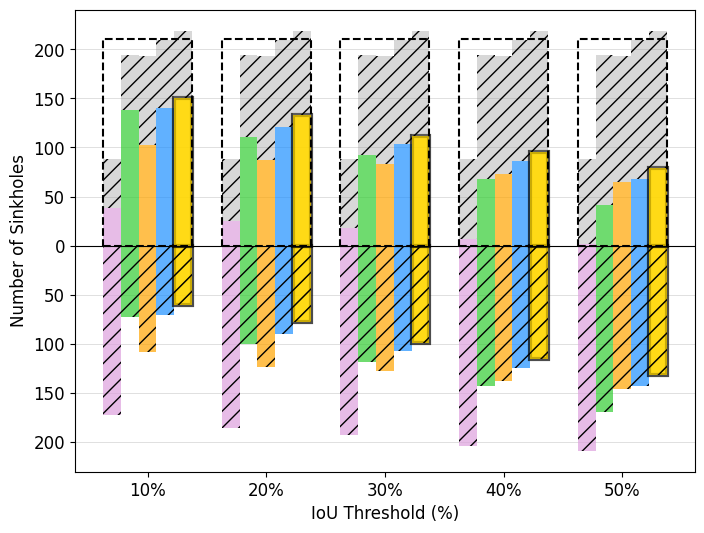

In [18]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

# Set global font size
plt.rcParams.update({'font.size': 12})  # Adjust the font size as needed

# Load the saved metrics
with open('iou_thresholds.pkl', 'rb') as f:
    iou_thresholds = pickle.load(f)

with open('conf_matrices.pkl', 'rb') as f:
    all_conf_matrices = pickle.load(f)

# Define the maximum IoU threshold to plot
max_threshold = 0.5

# Find the index of the maximum threshold
max_index = np.where(iou_thresholds <= max_threshold)[0][-1]

# Filter the thresholds and confusion matrices up to the max_threshold
iou_thresholds = iou_thresholds[:max_index + 1]
all_conf_matrices = [conf_matrix[:max_index + 1] for conf_matrix in all_conf_matrices]

# Number of IoU thresholds and models
num_thresholds = len(iou_thresholds)
num_models = len(all_conf_matrices)

# Initialize lists to store predicted sinkholes (TP), false positives (FP), and false negatives (FN)
predicted_sinkholes = np.zeros((num_models, num_thresholds))
false_positives = np.zeros((num_models, num_thresholds))
false_negatives = np.zeros((num_models, num_thresholds))
actual_sinkholes = np.zeros(num_thresholds)  # Number of actual sinkholes (TP + FN)

# Extract values from confusion matrices
for t in range(num_thresholds):
    for i in range(num_models):
        conf_matrix = all_conf_matrices[i][t]
        predicted_sinkholes[i, t] = conf_matrix[1, 1]  # TP
        false_positives[i, t] = conf_matrix[0, 1]  # FP
        false_negatives[i, t] = conf_matrix[1, 0]  # FN
    
    # Actual sinkholes are the same across all models for a given threshold
    actual_sinkholes[t] = predicted_sinkholes[0, t] + false_negatives[0, t]

# Plotting
plt.figure(figsize=(8, 6))
colors = ['#DDA0DD', '#32CD32', '#FFA500', '#1E90FF', '#FFD700']
bar_width = 0.15  # Width of each bar

# Add light gray horizontal grid lines behind the bars
plt.grid(True, which='major', axis='y', color='lightgray', linestyle='-', linewidth=0.5, zorder=1)
plt.grid(False, which='major', axis='x')

for i in range(num_models):
    if colors[i] == '#FFD700':  # Check if the color is yellow
        path_effects = [PathEffects.withStroke(linewidth=3, foreground='black')]
    else:
        path_effects = []

    # Plot the false negatives as bars below zero with a hatch pattern
    plt.bar(np.arange(num_thresholds) + i * bar_width, -false_negatives[i], color=colors[i], width=bar_width, alpha=0.7, hatch='//', zorder=2, label=f'FN - Model {i+1}', path_effects=path_effects)

    # Plot the true positives as the base of the bars with a halo if it's the yellow model
    plt.bar(np.arange(num_thresholds) + i * bar_width, predicted_sinkholes[i], color=colors[i], width=bar_width, alpha=0.7, zorder=2, label=f'TP - Model {i+1}', path_effects=path_effects)

    # Stack the false positives on top of the true positives without a halo for gray bars
    plt.bar(np.arange(num_thresholds) + i * bar_width, false_positives[i], bottom=predicted_sinkholes[i], color='gray', width=bar_width, alpha=0.3, hatch='//', zorder=2, label=f'FP - Model {i+1}')

# Adjust the y-ticks to display positive labels only, even for negative values
y_ticks = np.arange(-200, 250, 50)
y_labels = [f'{abs(yt)}' for yt in y_ticks]
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels(y_labels)

# Add the actual sinkholes as a box frame on top of the positive bars
for t in range(num_thresholds):
    plt.gca().add_patch(plt.Rectangle((t - 0.5 * bar_width, 0), num_models * bar_width, actual_sinkholes[t], fill=None, edgecolor='black', linewidth=1.5, linestyle='--', zorder=3))

# Update x-tick labels to show percentages instead of decimals
percentage_labels = [f'{th * 100:.0f}%' for th in iou_thresholds]
plt.xlabel('IoU Threshold (%)')
plt.ylabel('Number of Sinkholes')
plt.xticks(np.arange(num_thresholds) + (num_models / 2 - 0.5) * bar_width, percentage_labels)
plt.axhline(0, color='black', linewidth=0.8, zorder=2)  # Add a line at y=0

# Save the plot at 600 dpi
plt.savefig('confusion.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()


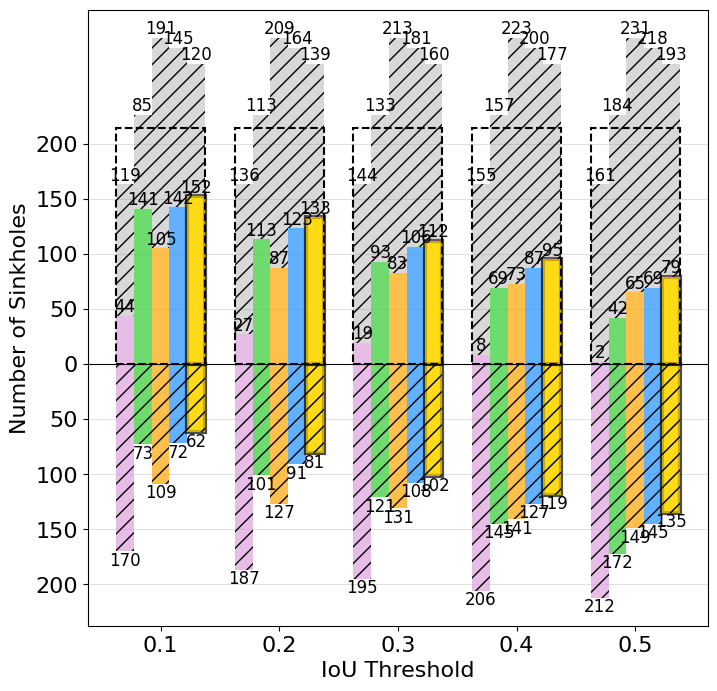

In [11]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

# Set global font size
plt.rcParams.update({'font.size': 16})  # Adjust the font size as needed

# Load the saved metrics
with open('iou_thresholds.pkl', 'rb') as f:
    iou_thresholds = pickle.load(f)

with open('conf_matrices.pkl', 'rb') as f:
    all_conf_matrices = pickle.load(f)

# Define the maximum IoU threshold to plot
max_threshold = 0.5

# Find the index of the maximum threshold
max_index = np.where(iou_thresholds <= max_threshold)[0][-1]

# Filter the thresholds and confusion matrices up to the max_threshold
iou_thresholds = iou_thresholds[:max_index + 1]
all_conf_matrices = [conf_matrix[:max_index + 1] for conf_matrix in all_conf_matrices]

# Number of IoU thresholds and models
num_thresholds = len(iou_thresholds)
num_models = len(all_conf_matrices)

# Initialize lists to store predicted sinkholes (TP), false positives (FP), and false negatives (FN)
predicted_sinkholes = np.zeros((num_models, num_thresholds))
false_positives = np.zeros((num_models, num_thresholds))
false_negatives = np.zeros((num_models, num_thresholds))
actual_sinkholes = np.zeros(num_thresholds)  # Number of actual sinkholes (TP + FN)

# Extract values from confusion matrices
for t in range(num_thresholds):
    for i in range(num_models):
        conf_matrix = all_conf_matrices[i][t]
        predicted_sinkholes[i, t] = conf_matrix[1, 1]  # TP
        false_positives[i, t] = conf_matrix[0, 1]  # FP
        false_negatives[i, t] = conf_matrix[1, 0]  # FN
    
    # Actual sinkholes are the same across all models for a given threshold
    actual_sinkholes[t] = predicted_sinkholes[0, t] + false_negatives[0, t]

# Plotting
plt.figure(figsize=(8, 8))
colors = ['#DDA0DD', '#32CD32', '#FFA500', '#1E90FF', '#FFD700']
bar_width = 0.15  # Width of each bar

# Add light gray horizontal grid lines behind the bars
plt.grid(True, which='major', axis='y', color='lightgray', linestyle='-', linewidth=0.5, zorder=1)
plt.grid(False, which='major', axis='x')

for i in range(num_models):
    if colors[i] == '#FFD700':  # Check if the color is yellow
        path_effects = [PathEffects.withStroke(linewidth=3, foreground='black')]
    else:
        path_effects = []

    # Plot the false negatives as bars below zero with a hatch pattern
    plt.bar(np.arange(num_thresholds) + i * bar_width, -false_negatives[i], color=colors[i], width=bar_width, alpha=0.7, hatch='//', zorder=2, label=f'FN - Model {i+1}', path_effects=path_effects)

    # Plot the true positives as the base of the bars with a halo if it's the yellow model
    plt.bar(np.arange(num_thresholds) + i * bar_width, predicted_sinkholes[i], color=colors[i], width=bar_width, alpha=0.7, zorder=2, label=f'TP - Model {i+1}', path_effects=path_effects)

    # Stack the false positives on top of the true positives without a halo for gray bars
    plt.bar(np.arange(num_thresholds) + i * bar_width, false_positives[i], bottom=predicted_sinkholes[i], color='gray', width=bar_width, alpha=0.3, hatch='//', zorder=2, label=f'FP - Model {i+1}')

    # Add number labels to each bar (TP, FP, and FN)
    for j in range(num_thresholds):
        # For TP
        plt.text(j + i * bar_width, predicted_sinkholes[i, j], f'{int(predicted_sinkholes[i, j])}', ha='center', va='bottom', fontsize=12, zorder=4)
        # For FP
        plt.text(j + i * bar_width, predicted_sinkholes[i, j] + false_positives[i, j], f'{int(false_positives[i, j])}', ha='center', va='bottom', fontsize=12, zorder=4)
        # For FN
        plt.text(j + i * bar_width, -false_negatives[i, j], f'{int(false_negatives[i, j])}', ha='center', va='top', fontsize=12, zorder=4)

# Adjust the y-ticks to display positive labels only, even for negative values
y_ticks = np.arange(-200, 250, 50)
y_labels = [f'{abs(yt)}' for yt in y_ticks]
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels(y_labels)

# Add the actual sinkholes as a box frame on top of the positive bars
for t in range(num_thresholds):
    plt.gca().add_patch(plt.Rectangle((t - 0.5 * bar_width, 0), num_models * bar_width, actual_sinkholes[t], fill=None, edgecolor='black', linewidth=1.5, linestyle='--', zorder=3))

plt.xlabel('IoU Threshold')
plt.ylabel('Number of Sinkholes')
plt.xticks(np.arange(num_thresholds) + (num_models / 2 - 0.5) * bar_width, [f'{th:.1f}' for th in iou_thresholds])
plt.axhline(0, color='black', linewidth=0.8, zorder=2)  # Add a line at y=0

# Save the plot at 600 dpi
plt.savefig('confusion.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()


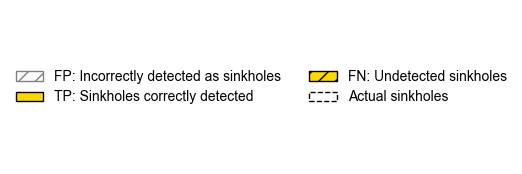

In [256]:
import matplotlib.pyplot as plt

# Set global font size and other font properties
plt.rcParams.update({
    'font.size': 20,
})

# Define the styles for the legend
legend_data = {
    "FP: Incorrectly detected as sinkholes": {'facecolor': 'none', 'edgecolor': 'gray', 'hatch': '//'},  # Gray with lines
    "TP: Sinkholes correctly detected": {'facecolor': '#FFD700', 'edgecolor': 'black'},  # Solid color (yellow here)
    "FN: Undetected sinkholes": {'facecolor': '#FFD700', 'edgecolor': 'black', 'hatch': '//'},  # Color with black hatch lines
    "Actual sinkholes": {'facecolor': 'none', 'edgecolor': 'black', 'linestyle': '--'}  # Dashed outline
}

# Create a figure for the legend
plt.figure(figsize=(6, 2))  # Adjust the size as needed to accommodate two columns

# Create handles for the legend using the defined styles
handles = []
for label, style in legend_data.items():
    handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=style.get('facecolor', 'none'), edgecolor=style.get('edgecolor', 'black'), 
                                  hatch=style.get('hatch', ''), linestyle=style.get('linestyle', 'solid')))

# Create the legend
legend = plt.legend(handles, list(legend_data.keys()), loc='center', fontsize=10, frameon=False, ncol=2)  # ncol=2 for two columns

# Remove axis and background from the legend plot
plt.gca().set_frame_on(False)
plt.gca().axis('off')

# Save the legend as a separate file
plt.savefig('legend_only_with_correct_symbols_horizontal.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()


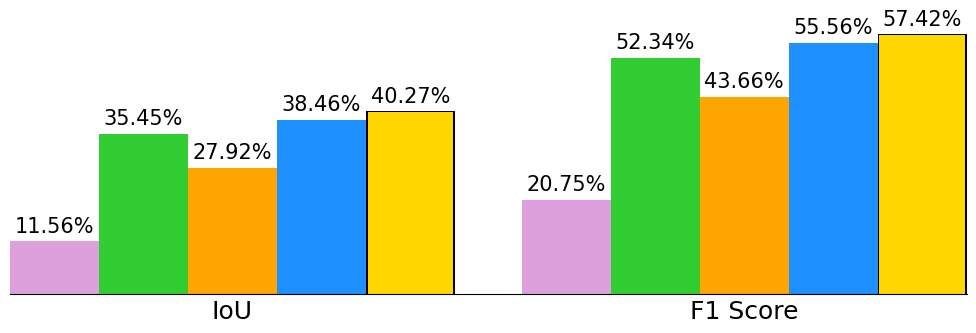

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Define lighter versions of each color
mean_colors = {
    "Depressions (DEM)": "#DDA0DD",  # light purple
    "Depressions (Mono-Depth)": "#32CD32",  # light green
    "Tuned SAM prompted by YOLOv9": "#FFA500",  # light orange
    "SAM prompted by Mono-Depth": "#1E90FF",  # light blue
    "Tuned SAM prompted by Mono-Depth": "#FFD700"  # light gold (yellow)
}

# Updated mean data based on the provided table
mean_data = {
    "Model": [
        "Depressions (DEM)",
        "Depressions (Mono-Depth)",
        "Tuned SAM prompted by YOLOv9",
        "SAM prompted by Mono-Depth",
        "Tuned SAM prompted by Mono-Depth"
    ],
    "IoU": [11.56, 35.45, 27.92, 38.46, 40.27],
    "F1-score": [20.75, 52.34, 43.66, 55.56, 57.42]
}

df_mean = pd.DataFrame(mean_data)

# Plotting IoU and F1 Score for mean in separate groups on the same plot
plt.figure(figsize=(10, 3.5))
bar_width = 0.4  # Adjusting the bar width
group_gap = 0.3  # Reduced gap between IoU and F1 groups

# Create positions for IoU bars and F1 Score bars
positions_miou = [i * bar_width for i in range(len(df_mean))]
positions_f1 = [i + len(df_mean) * bar_width + group_gap for i in positions_miou]

# Function to plot bars with consistent outline
def plot_bars_with_consistent_outline(positions, values, color, add_outline=False):
    for pos, val in zip(positions, values):
        if add_outline:
            plt.bar(pos, val + 0.15, width=bar_width * 1, color='black', label='_nolegend_')  # Outline
            plt.bar(pos, val, width=bar_width * 0.96, color=color)  # Main bar
        else:
            plt.bar(pos, val, width=bar_width, color=color)

# Apply consistent outline effect for the yellow bars
iou_values = df_mean['IoU']
f1_values = df_mean['F1-score']
for i, (model, color) in enumerate(zip(df_mean['Model'], mean_colors.values())):
    is_yellow = color == '#FFD700'
    plot_bars_with_consistent_outline([positions_miou[i]], [iou_values[i]], color, add_outline=is_yellow)
    plot_bars_with_consistent_outline([positions_f1[i]], [f1_values[i]], color, add_outline=is_yellow)

# Adding labels and titles
for pos, iou in zip(positions_miou, iou_values):
    plt.text(pos, iou + 1.3, f"{iou:.2f}%", ha='center', va='bottom', fontsize=15)
for pos, f1 in zip(positions_f1, f1_values):
    plt.text(pos, f1 + 1.3, f"{f1:.2f}%", ha='center', va='bottom', fontsize=15)

plt.xticks([])  # Remove x-axis labels

# Set labels and annotations
plt.annotate('IoU', xy=(sum(positions_miou) / len(positions_miou), -0.02), xycoords=('data', 'axes fraction'), fontsize=18, ha='center', va='top')
plt.annotate('F1 Score', xy=(sum(positions_f1) / len(positions_f1), -0.02), xycoords=('data', 'axes fraction'), fontsize=18, ha='center', va='top')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().yaxis.set_ticks([])  # Remove y-axis ticks
plt.grid(False)  # Remove the grid lines

# Set x-axis limits to cover the range of bar positions
plt.xlim(min(positions_miou) - bar_width / 2, max(positions_f1) + bar_width / 2)

plt.tight_layout()
plt.savefig('mean_combined_plot_with_titles_adjusted.png', dpi=600, transparent=True)
plt.show()


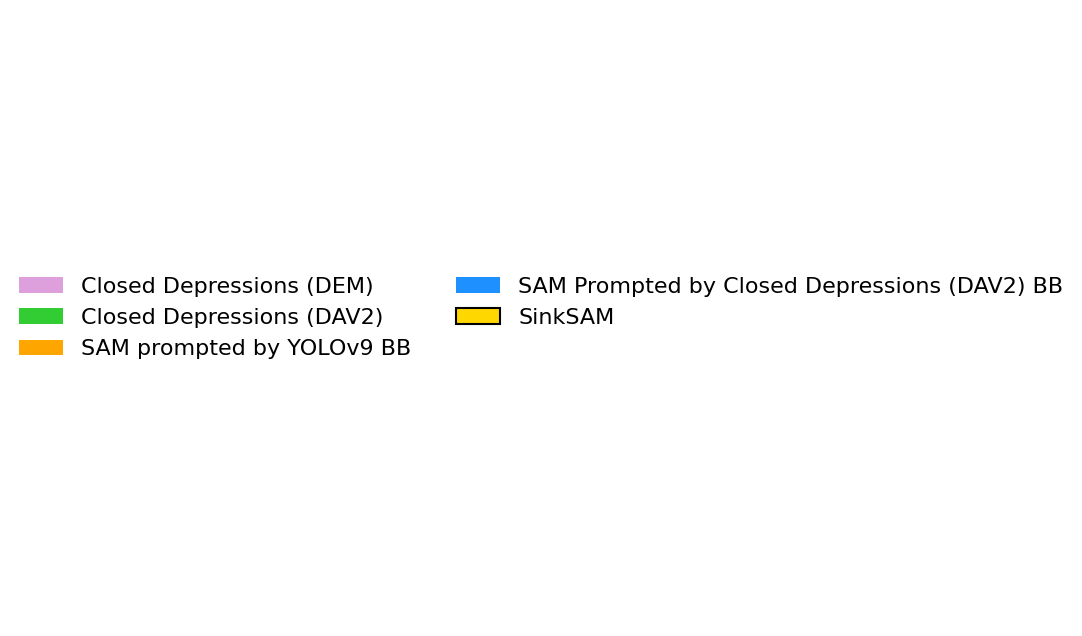

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define lighter versions of each color for the legend
mean_colors = {
    "Closed Depressions (DEM)": "#DDA0DD",  # light purple
    "Closed Depressions (DAV2)": "#32CD32",  # light green
    "SAM prompted by YOLOv9 BB": "#FFA500",  # light orange
    "SAM Prompted by Closed Depressions (DAV2) BB": "#1E90FF",  # light blue
    "SinkSAM": "#FFD700"  # light gold
}
# Create a figure for the legend
plt.figure(figsize=(12, 8))

# Create a custom handle for the yellow color with a black outline
handles = []
for label in mean_colors:
    if mean_colors[label] == '#FFD700':  # Check if it's the yellow color
        patch = mpatches.Rectangle((0, 0), 1, 1, facecolor=mean_colors[label], edgecolor='black', linewidth=1.5)
    else:
        patch = mpatches.Rectangle((0, 0), 1, 1, facecolor=mean_colors[label])
    handles.append(patch)

# Add the legend to the plot
legend = plt.legend(handles, list(mean_colors.keys()), loc='center', ncol=2, fontsize=16, frameon=False)  # ncol=2 for a square-like layout

# Remove axis and background from the legend plot
plt.gca().set_frame_on(False)
plt.gca().axis('off')

# Save the legend as a separate file
plt.savefig('legend_only_with_yellow_outline.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()
